### Import Library dan Dataset

In [37]:
import os
import gc
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [23]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [24]:
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [25]:
EPOCHS = 3
BATCH_SIZE = 16
LR = 2e-5
MAX_LEN = 128

In [26]:
# GPU memory growth (safe for tf-nightly)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception as e:
            print("Warning: set_memory_growth failed:", e)

# Mixed precision (optional, often supported in tf-nightly)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled:", mixed_precision.global_policy())
except Exception as e:
    print("Mixed precision unavailable or failed:", e)

# helper to free memory between trials/folds


def free_mem():
    try:
        tf.keras.backend.clear_session()
    except Exception:
        pass
    gc.collect()


print("TensorFlow version:", tf.__version__)
print("Num GPUs:", len(gpus))

Mixed precision enabled: <Policy "mixed_float16">
TensorFlow version: 2.19.0
Num GPUs: 1


In [27]:
df = pd.read_csv('/content/drive/MyDrive/Skripsi/data_cleaned.csv')
df.head()

,Tweet,Label
0,saya takut kehilangan hal kecil,Takut
1,tidak ada cahaya buat dituju,Sedih
2,rasanya like semuanya sinkron,Gembira
3,yaallah mika angkasa saya kaget saya kira cuma...,Takut
4,saya cemas sejak tadi pagi,Takut


### Persiapan Dataset

In [102]:
le = LabelEncoder()
df['LabelEncoded'] = le.fit_transform(df['Label'])
label_names = le.classes_.tolist()
num_labels = len(label_names)

print(f"Total samples: {len(df)}")
print(f"Number of labels: {num_labels}")
print(f"Label mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Total samples: 10075
Number of labels: 5
Label mapping: {'Cinta': np.int64(0), 'Gembira': np.int64(1), 'Marah': np.int64(2), 'Sedih': np.int64(3), 'Takut': np.int64(4)}


In [103]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["Tweet"].tolist(),
    df["LabelEncoded"].tolist(),
    test_size=0.30,  # 30% = 3000 samples untuk val + test
    stratify=df["LabelEncoded"],
    random_state=SEED
)

# Split temp menjadi val dan test
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.50,  # 15% dari total = 1500 samples untuk test
    stratify=temp_labels,
    random_state=SEED
)

print(f"Train: {len(train_texts):,} samples")
print(f"Val: {len(val_texts):,} samples")
print(f"Test: {len(test_texts):,} samples (UNTOUCHED)")
print(f"Label distribution in Train: {np.bincount(train_labels)}")
print(f"Label distribution in Val: {np.bincount(val_labels)}")
print(f"Label distribution in Test: {np.bincount(test_labels)}")

Train: 7,052 samples
Val: 1,511 samples
Test: 1,512 samples (UNTOUCHED)
Label distribution in Train: [1167 1681 1432 1405 1367]
Label distribution in Val: [250 360 307 301 293]
Label distribution in Test: [250 361 307 301 293]


### Tokenisasi

In [104]:
MODEL_NAME = "/content/drive/MyDrive/Skripsi/local-xlmr-tf"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_texts(texts, max_len=MAX_LEN):
    return tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

train_encodings = tokenize_texts(train_texts)
val_encodings = tokenize_texts(val_texts)
test_encodings = tokenize_texts(test_texts)

In [105]:
# Batching dataset
def create_tf_dataset(encodings, labels, batch_size=BATCH_SIZE, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))

    if shuffle:
        dataset = dataset.shuffle(1000)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_dataset = create_tf_dataset(train_encodings, train_labels, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = create_tf_dataset(val_encodings, val_labels, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = create_tf_dataset(test_encodings, test_labels, batch_size=BATCH_SIZE, shuffle=False)

### Modelling

In [ ]:
def build_model(num_labels=5):
    model = TFAutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels,
        local_files_only=True
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    return model

### Cross Validation

In [33]:
fold_texts, test_texts, fold_labels, test_labels = train_test_split(
    df["Tweet"].tolist(),
    df["LabelEncoded"].tolist(),
    test_size=0.15,  # 15% = 1500 samples untuk val + test
    stratify=df["LabelEncoded"],
    random_state=SEED
)

# Split temp menjadi val dan test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    fold_texts,
    fold_labels,
    test_size=0.1765,  # 15% dari total = 1500 samples untuk val
    stratify=fold_labels,
    random_state=SEED
)

fold_labels = np.array(fold_labels)

In [38]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(fold_texts, fold_labels), 1):
    print(f"\n===== Fold {fold} =====")

    X_train = [fold_texts[i] for i in train_idx]
    y_train = fold_labels[train_idx]
    X_val = [fold_texts[i] for i in val_idx]
    y_val = fold_labels[val_idx]

    train_enc = tokenize_texts(X_train)
    val_enc = tokenize_texts(X_val)

    model = build_model(num_labels=5)

    model.fit(
        x=dict(train_enc),
        y=y_train,
        validation_data=(dict(val_enc), y_val),
        batch_size=32,
        epochs=3,
        verbose=1
    )

    # Prediction
    val_logits = model.predict(dict(val_enc)).logits
    val_preds = np.argmax(val_logits, axis=1)

    acc = accuracy_score(y_val, val_preds)
    f1 = f1_score(y_val, val_preds, average='macro')

    fold_results.append({
        "fold": fold,
        "accuracy": acc,
        "macro_f1": f1
    })

    print(f"Fold {fold} | Acc: {acc:.4f} | Macro-F1: {f1:.4f}")
    free_mem()


===== Fold 1 =====


All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

All the layers of TFXLMRobertaForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Skripsi/local-xlmr-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


Epoch 1/3
215/215 [==============================] - 171s 525ms/step - loss: 1.0402 - accuracy: 0.5945 - val_loss: 0.3970 - val_accuracy: 0.8780
Epoch 2/3
215/215 [==============================] - 91s 422ms/step - loss: 0.4229 - accuracy: 0.8673 - val_loss: 0.3345 - val_accuracy: 0.8885
Epoch 3/3
54/54 [==============================] - 9s 116ms/step
Fold 1 | Acc: 0.8914 | Macro-F1: 0.8902

===== Fold 2 =====


All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

All the layers of TFXLMRobertaForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Skripsi/local-xlmr-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


Epoch 1/3
215/215 [==============================] - 169s 525ms/step - loss: 1.0325 - accuracy: 0.6003 - val_loss: 0.4564 - val_accuracy: 0.8523
Epoch 2/3
215/215 [==============================] - 92s 427ms/step - loss: 0.4566 - accuracy: 0.8536 - val_loss: 0.4062 - val_accuracy: 0.8774
Epoch 3/3
54/54 [==============================] - 10s 115ms/step
Fold 2 | Acc: 0.8745 | Macro-F1: 0.8744

===== Fold 3 =====


All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

All the layers of TFXLMRobertaForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Skripsi/local-xlmr-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


Epoch 1/3
215/215 [==============================] - 172s 529ms/step - loss: 1.0095 - accuracy: 0.6115 - val_loss: 0.4730 - val_accuracy: 0.8471
Epoch 2/3
215/215 [==============================] - 89s 415ms/step - loss: 0.4320 - accuracy: 0.8616 - val_loss: 0.4090 - val_accuracy: 0.8704
Epoch 3/3
54/54 [==============================] - 9s 117ms/step
Fold 3 | Acc: 0.8786 | Macro-F1: 0.8772

===== Fold 4 =====


All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

All the layers of TFXLMRobertaForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Skripsi/local-xlmr-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


Epoch 1/3
215/215 [==============================] - 169s 522ms/step - loss: 0.9937 - accuracy: 0.6193 - val_loss: 0.4189 - val_accuracy: 0.8639
Epoch 2/3
215/215 [==============================] - 89s 415ms/step - loss: 0.4188 - accuracy: 0.8650 - val_loss: 0.3690 - val_accuracy: 0.8832
Epoch 3/3
54/54 [==============================] - 10s 114ms/step
Fold 4 | Acc: 0.8820 | Macro-F1: 0.8812

===== Fold 5 =====


All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

All the layers of TFXLMRobertaForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Skripsi/local-xlmr-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


Epoch 1/3
215/215 [==============================] - 175s 533ms/step - loss: 1.0170 - accuracy: 0.6078 - val_loss: 0.4758 - val_accuracy: 0.8405
Epoch 2/3
215/215 [==============================] - 93s 433ms/step - loss: 0.4318 - accuracy: 0.8634 - val_loss: 0.4044 - val_accuracy: 0.8692
Epoch 3/3
54/54 [==============================] - 10s 115ms/step
Fold 5 | Acc: 0.8797 | Macro-F1: 0.8794


In [39]:
accs = [r["accuracy"] for r in fold_results]
f1s = [r["macro_f1"] for r in fold_results]

print("\n===== K-FOLD SUMMARY =====")
print(f"Folds: {len(fold_results)}")
print(f"Accuracy per fold: {[f'{r['accuracy']:.4f}' for r in fold_results]}")
print(f"Macro-F1 per fold: {[f'{r['macro_f1']:.4f}' for r in fold_results]}")
print(f"Mean Accuracy : {np.mean(accs):.4f}")
print(f"Mean Macro-F1 : {np.mean(f1s):.4f}")


===== K-FOLD SUMMARY =====
Folds: 5
Accuracy per fold: ['0.8914', '0.8745', '0.8786', '0.8820', '0.8797']
Macro-F1 per fold: ['0.8902', '0.8744', '0.8772', '0.8812', '0.8794']
Mean Accuracy : 0.8812
Mean Macro-F1 : 0.8805


### Fine Tuning

In [107]:
free_mem()

In [108]:
model = build_model(num_labels=num_labels)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1
)

All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

All the layers of TFXLMRobertaForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Skripsi/local-xlmr-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


Epoch 1/3
441/441 [==============================] - 208s 321ms/step - loss: 1.2367 - accuracy: 0.5088 - val_loss: 0.6087 - val_accuracy: 0.8081
Epoch 2/3
441/441 [==============================] - 108s 246ms/step - loss: 0.5519 - accuracy: 0.8351 - val_loss: 0.4186 - val_accuracy: 0.8617
Epoch 3/3
441/441 [==============================] - 108s 244ms/step - loss: 0.3940 - accuracy: 0.8780 - val_loss: 0.4046 - val_accuracy: 0.8756


### Evaluasi

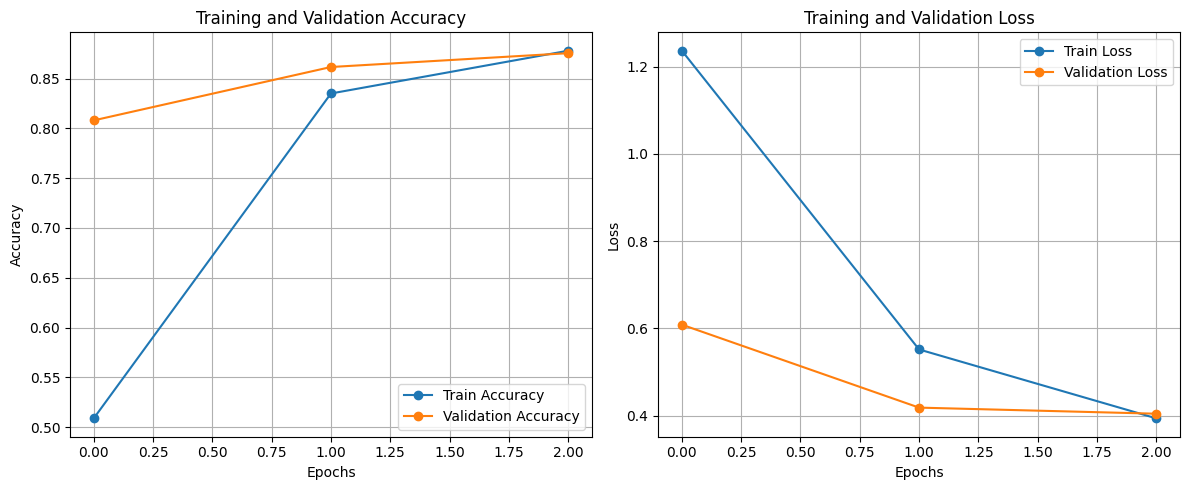

In [109]:
# Visualisasi Learning Curve
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'],
         label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [110]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")




FINAL RESULTS
Test Loss: 0.3947
Test Accuracy: 0.8730


In [111]:
# Predictions dan detailed report
pred_logits = model.predict(test_dataset, verbose=0).logits
pred_labels = np.argmax(pred_logits, axis=1)

print("\nCLASSIFICATION REPORT:")
print(classification_report(test_labels, pred_labels,
                            target_names=label_names, digits=4))


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Cinta     0.8654    0.9000    0.8824       250
     Gembira     0.9275    0.8504    0.8873       361
       Marah     0.8664    0.8664    0.8664       307
       Sedih     0.8176    0.8638    0.8401       301
       Takut     0.8851    0.8942    0.8896       293

    accuracy                         0.8730      1512
   macro avg     0.8724    0.8750    0.8732      1512
weighted avg     0.8747    0.8730    0.8733      1512



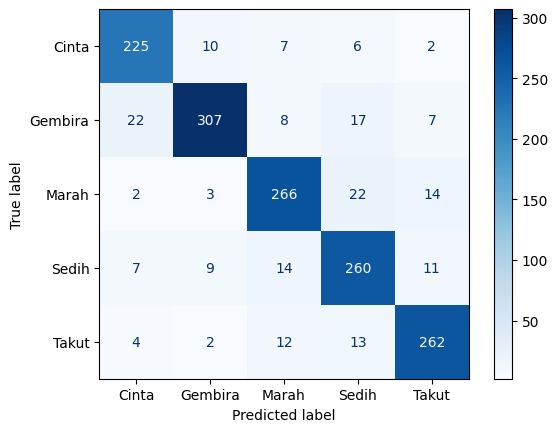

In [112]:
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)

In [113]:
SAVE_DIR = "/content/drive/MyDrive/Skripsi//XLMR_Model"

os.makedirs(SAVE_DIR, exist_ok=True)

model.save_pretrained(f'{SAVE_DIR}',save_format="tf")
tokenizer.save_pretrained(f'{SAVE_DIR}',save_format="tf")

('/content/drive/MyDrive/Skripsi//XLMR_Model/tokenizer_config.json',
 '/content/drive/MyDrive/Skripsi//XLMR_Model/special_tokens_map.json',
 '/content/drive/MyDrive/Skripsi//XLMR_Model/tokenizer.json')

### Inferensi Model

In [114]:
MODEL_PATH = SAVE_DIR
TOKENIZER_PATH = SAVE_DIR

In [115]:
#Load tokenizer dan model
inference_tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)
inference_model = TFAutoModelForSequenceClassification.from_pretrained(SAVE_DIR)

All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

All the layers of TFXLMRobertaForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Skripsi//XLMR_Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


In [116]:
EXTERNAL_TEST_PATH = "/content/drive/MyDrive/Skripsi/external_test.csv"


# Load external dataset
external_df = pd.read_csv(EXTERNAL_TEST_PATH)

# Cek struktur dataset
print(f"External dataset shape: {external_df.shape}")
print(f"Columns: {external_df.columns.tolist()}")
print(f"\n First few rows:")
print(external_df.head())

print(f"\nClass distribution in external data:")
print(external_df['Label'].value_counts())

External dataset shape: (1932, 2)
Columns: ['Label', 'Tweet']

 First few rows:
   Label                                          Tweet
0  Cinta          rasanya mirip hati saya disusun ulang
1  Cinta      rasanya mirip saya diselimuti rasa sayang
2  Cinta  rasanya mirip hati saya ditempel spark lembut
3  Cinta           saya suka tiap dia bilang saya cukup
4  Cinta           saya suka tiap dia ngulang kata saya

Class distribution in external data:
Label
Gembira    695
Sedih      580
Marah      275
Takut      223
Cinta      159
Name: count, dtype: int64


In [117]:
# Cek label yang ada di external data
external_labels = external_df['Label'].unique()
print(f"Unique labels in external data: {external_labels}")

Unique labels in external data: ['Cinta' 'Gembira' 'Marah' 'Sedih' 'Takut']


In [118]:
le.fit(label_names)  # Fit dengan label names yang konsisten

external_df['LabelEncoded'] = le.transform(external_df['Label'])
print(f"Final external dataset: {len(external_df)} samples")

Final external dataset: 1932 samples


In [119]:
# Tokenisasi external data
external_texts = external_df['Tweet'].tolist()
external_true_labels = external_df['LabelEncoded'].tolist()

def inference_tokenize_texts(texts, max_len=MAX_LEN):
    return inference_tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

external_encodings = inference_tokenize_texts(external_texts)

# Buat dataset
external_dataset = tf.data.Dataset.from_tensor_slices((
    dict(external_encodings),
    tf.convert_to_tensor(external_true_labels)
)).batch(16).prefetch(tf.data.AUTOTUNE)

In [120]:
# Recompile model
inference_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [121]:
# Evaluate model
external_loss, external_accuracy = inference_model.evaluate(external_dataset, verbose=0)

print("\n" + "="*60)
print("EXTERNAL TEST RESULTS - GENERALIZATION PERFORMANCE")
print("="*60)
print(f"External Test Loss: {external_loss:.4f}")
print(f"External Test Accuracy: {external_accuracy:.4f}")
print(f"Number of samples: {len(external_df)}")


EXTERNAL TEST RESULTS - GENERALIZATION PERFORMANCE
External Test Loss: 0.4209
External Test Accuracy: 0.8659
Number of samples: 1932


In [122]:
# Predictions
pred_logits = inference_model.predict(external_dataset, verbose=0).logits
pred_labels = np.argmax(pred_logits, axis=1)
pred_probs = tf.nn.softmax(pred_logits, axis=1)

# Classification Report
print("\nCLASSIFICATION REPORT (External Data):")
print(classification_report(
    external_true_labels,
    pred_labels,
    target_names=label_names,
    digits=4
))


CLASSIFICATION REPORT (External Data):
              precision    recall  f1-score   support

       Cinta     0.6119    0.8428    0.7090       159
     Gembira     0.9457    0.8777    0.9104       695
       Marah     0.8277    0.9782    0.8967       275
       Sedih     0.9312    0.8172    0.8705       580
       Takut     0.7949    0.8341    0.8140       223

    accuracy                         0.8659      1932
   macro avg     0.8223    0.8700    0.8401      1932
weighted avg     0.8797    0.8659    0.8688      1932



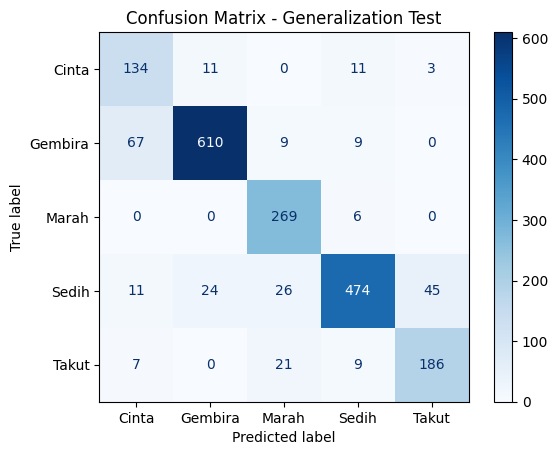

In [123]:
# Confusion Matrix
cm = confusion_matrix(external_true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.title(
    "Confusion Matrix - Generalization Test")
plt.show()